In [11]:
import os
import ember
import numpy as np
import pandas as pd
import altair as alt
import lightgbm as lgb
import matplotlib.pylab as plt
from sklearn.metrics import roc_auc_score, roc_curve
_ = alt.renderers.enable('notebook')

In [12]:
data_dir = "/data/ember2018/" # change this to where you unzipped the download

In [13]:
ember.create_vectorized_features(data_dir)
_ = ember.create_metadata(data_dir)

Vectorizing training set


100%|██████████| 800000/800000 [08:23<00:00, 1589.95it/s]


Vectorizing test set


100%|██████████| 200000/200000 [02:03<00:00, 1616.06it/s]


In [14]:
emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir)
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))

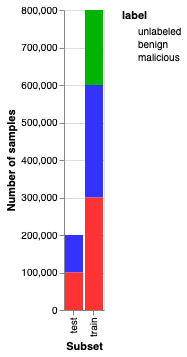

In [15]:
plotdf = emberdf.copy()
gbdf = plotdf.groupby(["label", "subset"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('subset:O', axis=alt.Axis(title='Subset')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=["#00b300", "#3333ff", "#ff3333"]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

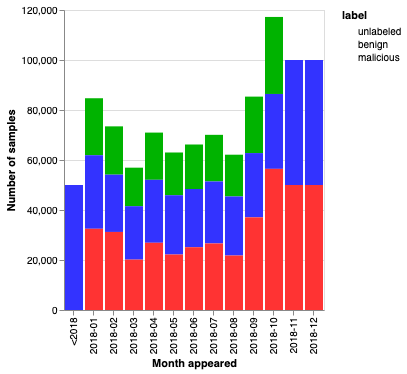

In [16]:
plotdf = emberdf.copy()
plotdf.loc[plotdf["appeared"] < "2018-01", "appeared"] = " <2018"
gbdf = plotdf.groupby(["appeared", "label"]).count().reset_index()
alt.Chart(gbdf).mark_bar().encode(
    alt.X('appeared:O', axis=alt.Axis(title='Month appeared')),
    alt.Y('sum(sha256):Q', axis=alt.Axis(title='Number of samples')),
    alt.Color('label:N', scale=alt.Scale(range=["#00b300", "#3333ff", "#ff3333"]), legend=alt.Legend(values=["unlabeled", "benign", "malicious"]))
)

In [17]:
y_test_pred = lgbm_model.predict(X_test)
y_train_pred = lgbm_model.predict(X_train)
emberdf["y_pred"] = np.hstack((y_train_pred, y_test_pred))

In [18]:
def get_fpr(y_true, y_pred):
    nbenign = (y_true == 0).sum()
    nfalse = (y_pred[y_true == 0] == 1).sum()
    return nfalse / float(nbenign)


def find_threshold(y_true, y_pred, fpr_target):
    thresh = 0.0
    fpr = get_fpr(y_true, y_pred > thresh)
    while fpr > fpr_target and thresh < 1.0:
        thresh += 0.0001
        fpr = get_fpr(y_true, y_pred > thresh)
    return thresh, fpr

testdf = emberdf[emberdf["subset"] == "test"]
print("ROC AUC:", roc_auc_score(testdf.label, testdf.y_pred))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.01)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))
print()

threshold, fpr = find_threshold(testdf.label, testdf.y_pred, 0.001)
fnr = (testdf.y_pred[testdf.label == 1] < threshold).sum() / float((testdf.label == 1).sum())
print("Ember Model Performance at 0.1% FPR:")
print("Threshold: {:.4f}".format(threshold))
print("False Positive Rate: {:.3f}%".format(fpr * 100))
print("False Negative Rate: {:.3f}%".format(fnr * 100))
print("Detection Rate: {}%".format(100 - fnr * 100))

ROC AUC: 0.9964289467999999

Ember Model Performance at 1% FPR:
Threshold: 0.8336
False Positive Rate: 1.000%
False Negative Rate: 3.502%
Detection Rate: 96.498%

Ember Model Performance at 0.1% FPR:
Threshold: 0.9996
False Positive Rate: 0.098%
False Negative Rate: 13.192%
Detection Rate: 86.80799999999999%


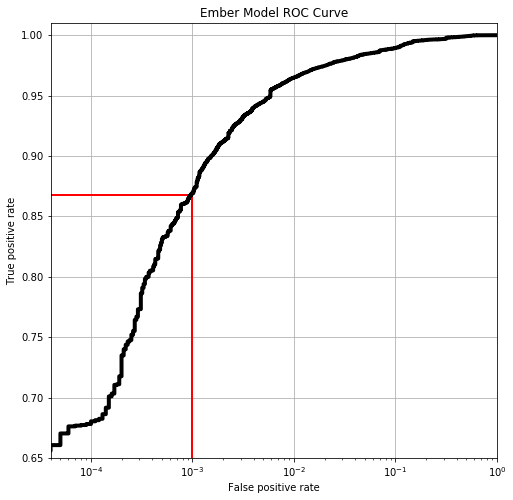

In [19]:
plt.figure(figsize=(8, 8))
fpr_plot, tpr_plot, _ = roc_curve(testdf.label, testdf.y_pred)
plt.plot(fpr_plot, tpr_plot, lw=4, color='k')
plt.gca().set_xscale("log")
plt.yticks(np.arange(22) / 20.0)
plt.xlim([4e-5, 1.0])
plt.ylim([0.65, 1.01])
plt.gca().grid(True)
plt.vlines(fpr, 0, 1 - fnr, color="r", lw=2)
plt.hlines(1 - fnr, 0, fpr, color="r", lw=2)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
_ = plt.title("Ember Model ROC Curve")

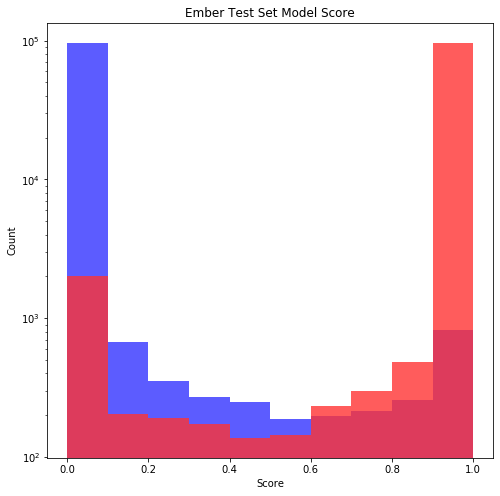

In [20]:
fig = plt.figure(figsize=(8, 8))
testdf[testdf["label"] == 0].y_pred.hist(range=[0, 1], bins=10, color="#3333ff", alpha=0.8, label="benign")
testdf[testdf["label"] == 1].y_pred.hist(range=[0, 1], bins=10, color="#ff3333", alpha=0.8, label="malicious")
plt.gca().set_yscale("log", nonposy="clip")
plt.gca().grid(False)
plt.xlabel("Score")
plt.ylabel("Count")
_ = plt.title("Ember Test Set Model Score")